In this notebook, we try to learn a function
$f(x) = v^\top x$ from samples
$(x_1, y_1), \ldots, (x_n, y_n)$
where $x \sim \mathcal{N}(0, I_d)$
and $y_i = f(x_i)$.

Method 1 will be linear regression with a pseudoinverse.
We will estimate $\hat{f}(x) = \hat{v}^\top x$
where $\hat{v} = \mathbf{X}^+ \mathbf{y}$
and $\mathbf{X}_{ij} = (x_i)_j$
and $\mathbf{y}_i = y_i$.

Method 2 will be k nearest neighbors,
where we use $L_2$ distance.

### Load libraries

In [1]:
import dataclasses
from typing import Callable

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

### Ground truth function

In [2]:
V_TRUE = np.random.normal(size=5)
F_TRUE = lambda xs: xs @ V_TRUE

### Learning algorithms

In [3]:
def estimate_linreg(xs: np.ndarray, ys: np.ndarray) -> Callable[[np.ndarray], np.ndarray]:
    v_hat = np.linalg.lstsq(xs, ys, rcond=None)[0]
    return lambda xs: xs @ v_hat

In [4]:
def estimate_knn(
    xs: np.ndarray,
    ys: np.ndarray,
    k: int,
) -> Callable[[np.ndarray], np.ndarray]:
    xs_copy = jnp.array(xs)
    ys_copy = jnp.array(ys)

    def f_hat(x: jnp.ndarray) -> jnp.ndarray:
        dists = jnp.linalg.norm(xs_copy - x.reshape(1, -1), axis=1)
        idxs = jnp.argsort(dists)
        return ys_copy[idxs[:k]].mean()

    return lambda xs: jax.jit(jax.vmap(f_hat))(xs).to_py()

### Test learning algorithm

In [5]:
def get_data(n: int, noise_std: float = 0) -> tuple[np.ndarray, np.ndarray]:
    xs = np.random.normal(size=(n, len(V_TRUE)))
    ys = F_TRUE(xs) + np.random.normal(size=n, scale=noise_std)
    return xs, ys

xs_train, ys_train = get_data(1000)
xs_test, ys_test = get_data(1000)


In [6]:
np.square(estimate_linreg(xs_train, ys_train)(xs_test) - ys_test).mean()

4.028332849578674e-30

In [7]:
np.square(estimate_knn(xs_train, ys_train, k=1)(xs_test) - ys_test).mean()

0.4840504198806758

### Scaling laws

In [8]:
@dataclasses.dataclass(frozen=True)
class ScalingData:
    ns: np.ndarray
    test_mses: np.ndarray

def run_scaling_exp(
    ns: list[int],
    estimator: Callable[[np.ndarray, np.ndarray], np.ndarray],
) -> np.ndarray:
    mses = []
    for n in tqdm(ns):
        xs_train, ys_train = get_data(n)

        f_hat = estimator(xs_train, ys_train)
        preds = f_hat(xs_test)

        mse = np.square(ys_test - preds).mean()
        mses.append(mse)

    return ScalingData(
        ns=np.array(ns),
        test_mses=np.array(mses),
    )

In [9]:
np.random.seed(42)
xs_test, ys_test = get_data(1000)
DATA = dict()

In [10]:
DATA["linreg"] = run_scaling_exp(
    ns=list(range(1, 100)),
    estimator=estimate_linreg,
)

  0%|          | 0/99 [00:00<?, ?it/s]

In [11]:
for k in [1, 10, 100]:
    DATA[f"{k}nn"] = run_scaling_exp(
        ns=[1, 2, 4, 8, 16, 32, 64, 100, 300, 1_000, 3_000, 10_000, 30_000],
        estimator=lambda xs, ys: estimate_knn(xs, ys, k=k),
    )

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

### Plots

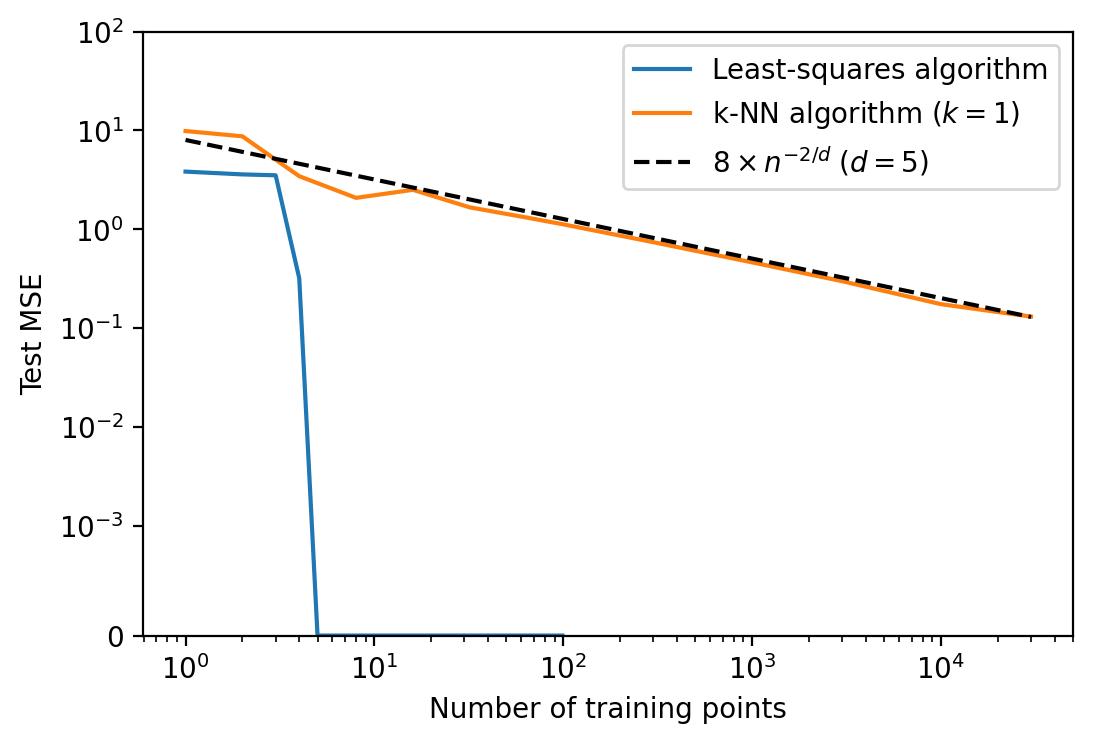

In [31]:
plt.figure(dpi=200)

plt.plot(DATA["linreg"].ns, DATA["linreg"].test_mses, label="Least-squares algorithm")
# for k in [1, 10, 100]:
for k in [1]:
    plt.plot(DATA[f"{k}nn"].ns, DATA[f"{k}nn"].test_mses, label=f"k-NN algorithm (${k=}$)")

plt.plot(
    np.arange(1, 30_000),
    8 * np.arange(1, 30_000) ** -(2 / 5),
    label=r"$8 \times n^{-2/d} \; (d = 5)$",
    linestyle="--",
    color="black",
)

# plt.title("Scaling laws for learning $f(x) = v^\\top x$ (dim=5)")
plt.xscale("log")
plt.yscale("symlog", linthresh=1e-3)
plt.ylim(0, 100)
plt.xlabel("Number of training points")
plt.ylabel("Test MSE")
plt.legend()
plt.show()